In [135]:
from bs4 import BeautifulSoup
import pandas as pd
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

# 1. Data Preprocessing

## 1.1 Parsing data 

In [ ]:
filenames = glob.glob("SensorData/*.xml")

for filename in filenames:
    path =filename
    filename = filename.replace("SensorData/", "").replace(".xml", "")
    with open(path) as f:
        sp = BeautifulSoup(f, "xml")
    
    ##### find periodic doc #####
    if 'PERIODIC' in filename:
        
        df_sensor = pd.DataFrame()
        df_reading = pd.DataFrame()
        
        ##### find sensor data #####
        if not sp.find_all('Sensor'):
            print("no Sensor data for", filename)

        for sensor in sp.find_all('Sensor'):

            if not sensor.Alarm:
                print("no alarm data for:", filename)

            for alarm in sensor.Alarms.find_all('Alarm'):
                ss = pd.Series()
                ss['gas_units'] = sensor.GasUnits.text
                ss['gas_type'] = sensor.GasType.text
                ss['site'] = sensor.Site.text
                ss['enabled'] = sensor.Enabled.text

                ss['alarm_type'] = alarm.AlarmType.text
                ss['enabled'] = alarm.Enabled.text
                ss['latching'] = alarm.Latching.text
                ss['setpoint'] = alarm.Setpoint.text

                df_sensor = df_sensor.append(ss, ignore_index = True)
        
        ##### find reading data #####
        if not sp.find_all('InstrumentRow'):
            print("no instrument data for", filename)

        for instrument in sp.find_all('InstrumentRow'):

            if not instrument.SensorReading:
                print("no reading data for", filename)
                
            for reading in instrument.Readings.find_all('SensorReading'):
                ss = pd.Series()
                ss['DateOccurred'] = instrument.DateOccurred.text
                ss['Temperature'] = instrument.Temperature.text
                ss['site'] = reading.Site.text
                ss['Average'] = reading.Average.text
                ss['Peak'] = reading.Peak.text

                df_reading = df_reading.append(ss, ignore_index = True)
        
        df_sensor.to_csv('ProcessedCSV/{}_sensor.csv'.format(filename))
        df_reading.to_csv('ProcessedCSV/{}_reading.csv'.format(filename))
        
            
    ##### find session doc #####   
    if 'SESSION' in filename:
        
        df_sensor = pd.DataFrame()
        df_reading = pd.DataFrame()
        
        ##### find sensor data #####
        if not sp.find_all('Sensor'):
            print("no Sensor data for", filename)

        for sensor in sp.find_all('Sensor'):

            if not sensor.Alarm:
                print("no alarm data for:", filename)

            for alarm in sensor.Alarms.find_all('Alarm'):
                ss = pd.Series()
                ss['gas_units'] = sensor.GasUnits.text
                ss['gas_type'] = sensor.GasType.text
                ss['site'] = sensor.Site.text
                ss['enabled'] = sensor.Enabled.text

                ss['alarm_type'] = alarm.AlarmType.text
                ss['enabled'] = alarm.Enabled.text
                ss['latching'] = alarm.Latching.text
                ss['setpoint'] = alarm.Setpoint.text

                df_sensor = df_sensor.append(ss, ignore_index = True)
        
        ##### find reading data #####
        if not sp.find_all('SingleSensorLog'):
            print("no reading data for", filename)
            
        for single_sensor in sp.find_all('SingleSensorLog'):
            
            for reading in single_sensor.find_all('SingleSensorRow'):
                ss = pd.Series()
                ss['TestType'] = single_sensor.TestType.text
                ss['FoundValue'] = single_sensor.FoundValue.text
                ss['ExpectedValue'] = single_sensor.ExpectedValue.text
                ss['CylinderLot'] = single_sensor.CylinderLot.text
                ss['CylinderPartNumber'] = single_sensor.CylinderPartNumber.text
                ss['Site'] = single_sensor.Site.text
                ss['GasUnit'] = single_sensor.GasUnit.text
                ss['IsFailed'] = single_sensor.IsFailed.text
                ss['Enabled'] = single_sensor.Enabled.text
                ss['DatePerformedUtc'] = single_sensor.DatePerformedUtc.text
                ss['Site'] = single_sensor.Site.text
                
                ss['DateOccurred'] = reading.DateOccurred.text
                ss['DateOccurredUtc'] = reading.DateOccurredUtc.text
                ss['Average'] = reading.Average.text
                ss['Peak'] = reading.Peak.text
                ss['Temperature'] = reading.Temperature.text
            
                df_reading = df_reading.append(ss, ignore_index = True)
                
        df_sensor.to_csv('ProcessedCSV/{}_sensor.csv'.format(filename))
        df_reading.to_csv('ProcessedCSV/{}_reading.csv'.format(filename))
        

# 1.2 Data collapse

In [ ]:
csvfiles = glob.glob("ProcessedCSV/*.csv")
dict_p = {}
dict_s = {}

for csvfile in csvfiles:
    path = csvfile
    csvname = csvfile.replace("ProcessedCSV/", "").replace(".csv", "")

    if "PERIODIC" in csvname:

        ID = csvname.replace('PERIODIC-DETAILS-LIST-', '').replace('_', '').replace('reading', '').replace('sensor' ,'')
        if ID not in dict_p:
            dict_p[ID] = {}

        if "sensor" in csvname:
            df_p_sensor = pd.read_csv(path)
            
            df_p_sensor = df_p_sensor.drop(['Unnamed: 0'], axis=1)
            
            dict_p[ID]['sensor'] = df_p_sensor
            
        if "reading" in csvname:
            df_p_reading = pd.read_csv(path)
            df_p_reading = df_p_reading.drop(['Unnamed: 0'], axis=1)
            dict_p[ID]['reading'] = df_p_reading
            
    if "SESSION" in csvname:
        ID = csvname.replace('SESSION-ALARM-DETAILS-', '').replace('_', '').replace('reading', '').replace('sensor' ,'')
        if ID not in dict_s:
            dict_s[ID] = {}
            
        if "sensor" in csvname:
            df_s_sensor = pd.read_csv(path)
            df_s_sensor = df_s_sensor.drop(['Unnamed: 0'], axis=1)
            dict_s[ID]['sensor'] = df_s_sensor
            
        if "reading" in csvname:
            df_s_reading = pd.read_csv(path)
            df_s_reading = df_s_reading.drop(['Unnamed: 0'], axis=1)
            if 'Site' in df_s_reading:
                df_s_reading['site'] = df_s_reading['Site']
                df_s_reading = df_s_reading.drop(['Site'], axis=1)
            dict_s[ID]['reading'] = df_s_reading
            

In [ ]:
lst_p = []
lst_s = []

for key, value in dict_p.items():
    df_sensor_temp = value['sensor'].drop(['alarm_type', 'enabled', 'latching', 'setpoint'], axis=1).drop_duplicates().reset_index(drop=True)

    if 'site' not in value['reading'] or 'site' not in df_sensor_temp:
        continue
    
    lst_p.append(value['reading'].merge(df_sensor_temp, on = 'site'))

for key, value in dict_s.items():
    df_sensor_temp = value['sensor'].drop(['alarm_type', 'enabled', 'latching', 'setpoint'], axis=1).drop_duplicates().reset_index(drop=True)

    if 'site' not in value['reading'].columns or 'site' not in df_sensor_temp.columns:
        continue
    
    lst_s.append(value['reading'].merge(df_sensor_temp, on = 'site'))


In [ ]:
df_p = pd.concat(lst_p).drop_duplicates().reset_index(drop=True)
df_s = pd.concat(lst_s).drop_duplicates().reset_index(drop=True)

In [ ]:
df_p.to_csv('ProcessedCSV/Collection/PERIODIC.csv', index = False)
df_s.to_csv('ProcessedCSV/Collection/SESSION.csv', index = False)

In [99]:
df_p = pd.read_csv('ProcessedCSV/Collection/PERIODIC.csv')
df_s = pd.read_csv('ProcessedCSV/Collection/SESSION.csv')

## 2. Feature Extraction

In [100]:
df_s = df_s[['Average', 'DateOccurred', 'Peak', 'Temperature', 'site', 'gas_type', 'gas_units']]
print(df_s.head())
print(df_p.head())

   Average         DateOccurred  Peak  Temperature  site gas_type   gas_units
0     0.50  1/5/2018 2:33:15 PM  0.50           28     1  Methane  PercentLEL
1     0.50  1/5/2018 2:34:15 PM  0.50           28     1  Methane  PercentLEL
2     0.45  1/5/2018 2:35:15 PM  0.50           28     1  Methane  PercentLEL
3     0.45  1/5/2018 2:36:15 PM  0.45           28     1  Methane  PercentLEL
4     0.00  1/5/2018 2:33:15 PM  0.00           28     3       CO  PercentLEL
   Average          DateOccurred  Peak  Temperature  site gas_type   gas_units
0      0.0  1/26/2018 5:34:45 AM   0.0           24     1  Methane  PercentLEL
1      0.0  1/26/2018 6:47:15 PM   0.0           26     1  Methane  PercentLEL
2      0.0  1/26/2018 6:48:15 PM   0.0           26     1  Methane  PercentLEL
3      0.0  1/26/2018 6:49:15 PM   0.0           26     1  Methane  PercentLEL
4      0.0  1/26/2018 6:50:15 PM   0.0           26     1  Methane  PercentLEL


In [101]:
df = pd.merge(df_p, df_s, on=['Average', 'DateOccurred', 'Peak', 'Temperature', 'site', 'gas_type', 'gas_units'], how='left', indicator='Exist')
# df.drop('Rating', inplace=True, axis=1)
df['Exist'] = np.where(df.Exist == 'both', 1, -1)
df.head()

,Average,DateOccurred,Peak,Temperature,site,gas_type,gas_units,Exist
0,0.0,1/26/2018 5:34:45 AM,0.0,24,1,Methane,PercentLEL,-1
1,0.0,1/26/2018 6:47:15 PM,0.0,26,1,Methane,PercentLEL,-1
2,0.0,1/26/2018 6:48:15 PM,0.0,26,1,Methane,PercentLEL,-1
3,0.0,1/26/2018 6:49:15 PM,0.0,26,1,Methane,PercentLEL,-1
4,0.0,1/26/2018 6:50:15 PM,0.0,26,1,Methane,PercentLEL,-1


In [102]:
df['DateOccurred'] = df['DateOccurred'].apply(lambda x: datetime.strptime(x.replace(" AM", "").replace(" PM", ""), '%m/%d/%Y %I:%M:%S'))

In [103]:
df['sin_day_of_week'] = df['DateOccurred'].dt.weekday.apply(lambda x: np.sin(2*np.pi*x/7))
df['cos_day_of_week'] = df['DateOccurred'].dt.weekday.apply(lambda x: np.cos(2*np.pi*x/7))
df['sin_hour_of_day'] = df['DateOccurred'].dt.hour.apply(lambda x: np.sin(2*np.pi*x/24))
df['cos_hour_of_day'] = df['DateOccurred'].dt.hour.apply(lambda x: np.cos(2*np.pi*x/24))
df['sin_time_of_day'] = df['DateOccurred'].apply(lambda x: np.sin(2*np.pi*(float(x.strftime("%H"))*60 + float(x.strftime("%M")))/60/24))
df['cos_time_of_day'] = df['DateOccurred'].apply(lambda x: np.cos(2*np.pi*(float(x.strftime("%H"))*60 + float(x.strftime("%M")))/60/24))
df['weekday'] = df['DateOccurred'].dt.weekday.apply(lambda x: 0 if (x == 6 or x == 5) else 1)
df = df.drop(['DateOccurred'],axis=1)

In [104]:
dummy_gastype = pd.get_dummies(df['gas_type'])
df = pd.concat([df, dummy_gastype], axis=1)
df.drop(['gas_units', 'gas_type'], axis=1, inplace=True)

In [185]:
df['Average_hot'] = df['Average'].apply(lambda x: 1 if x > 0 else 0)
df['Peak_hot'] = df['Peak'].apply(lambda x: 1 if x > 0 else 0)

In [188]:
df = df.drop(['Average', 'Peak'], axis=1)

In [190]:
df['Temperature'] = (df['Temperature'] - df['Temperature'].mean())/df['Temperature'].std()

In [198]:
df_set = pd.concat([df[df['Exist']==-1].sample(n=500, axis=0), df[df['Exist']==1]])

In [208]:
X = df_set.drop(['Exist'], axis=1)
y = df_set['Exist']

# 3. Model Construction

## 3.1 Training model

In [209]:
from sklearn.model_selection import train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size = 0.3, random_state=0)

In [214]:
from sklearn import linear_model

clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [231]:
print("Training socre: ", np.sum(clf.predict(X_train) == y_train) / len(y_train))
print("Baseline score:", np.sum(np.random.choice([1, -1], len(y_train)) == y_train) / len(y_train))

Training socre:  0.813880126183
Baseline score: 0.482649842271


## 3.2 Model selection

In [234]:
def cross_validation(c, X, y, X_test, y_test):
    clf = linear_model.LogisticRegression(C = c)
    clf.fit(X, y)
    train_score = np.sum(clf.predict(X) == y) / len(y)
    test_score = np.sum(clf.predict(X_test) == y_test) / len(y_test)
    
    return (train_score, test_score)

In [241]:
k=100
lst_train = []
lst_test = []
lst_k = np.logspace(-10, 10 ,k)
for c in lst_k:
    (train_score, test_score) = cross_validation(c, X_train, y_train, X_test, y_test)
    lst_train.append(train_score)
    lst_test.append(test_score)

train = np.array(lst_train)
test = np.array(lst_test)

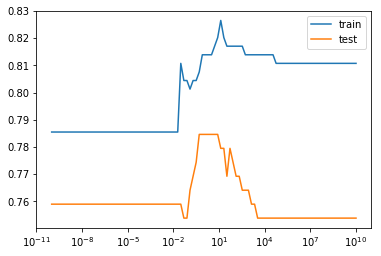

In [249]:
plt.plot(lst_k ,train)
plt.plot(lst_k, test)
plt.xscale('log')
plt.legend(['train', 'test'])
plt.show()

In [258]:
clf = linear_model.LogisticRegression(C= 1)
clf.fit(X_, y_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 3.3 Predicting

In [259]:
print("Training socre: ", np.sum(clf.predict(X_) == y_) / len(y_))
print("Test socre: ", np.sum(clf.predict(X_test) == y_test) / len(y_test))

Training socre:  0.808370044053
Test socre:  0.784615384615
